<a href="https://colab.research.google.com/github/mannampallavi22/Pallavi_Info5731_Fall2025/blob/main/Mannam_Pallavi_Assignment_4_INFO_5731_(1)_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment: 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) and BERTopic.**



**Expectations**:

*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100


NOTE: The output should be presented well to get **full points**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

**Dataset**: 20 Newsgroups dataset

**Dataset Link**: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

**Consider Random 2000 rows only**

Generate K=10 topics by using LDA and LSA,
then calculate coherence score and determine the optimized K value by the coherence score. Further, summarize and visualize each topics in you own words.


In [1]:
 !pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 71.4 MB/s eta 0:00:00



=== K = 5 ===
LDA coherence (c_v): 0.4976
LSA coherence (c_v): 0.4210

=== K = 10 ===
LDA coherence (c_v): 0.4699
LSA coherence (c_v): 0.3573

=== K = 15 ===
LDA coherence (c_v): 0.4450
LSA coherence (c_v): 0.3250

=== K = 20 ===
LDA coherence (c_v): 0.4716
LSA coherence (c_v): 0.3302

Best K for LDA: 5 with coherence: 0.49755885020029245
Best K for LSA: 5 with coherence: 0.42098523786446373

Top words per topic (LDA):
Topic 0: don, game, like, team, year, good, games, play, book, just
Topic 1: edu, use, data, file, available, ftp, program, using, windows, information
Topic 2: 00, 25, 20, 10, drive, 50, 40, 15, 16, 30
Topic 3: god, people, jesus, does, think, believe, know, say, don, new
Topic 4: don, think, just, people, know, said, like, going, president, mr

Top words per topic (LSA):
Topic 0: don, know, like, just, people, does, think, good, god, use
Topic 1: god, jesus, people, christ, believe, did, say, think, bible, christian
Topic 2: god, jesus, thanks, does, windows, christ, 

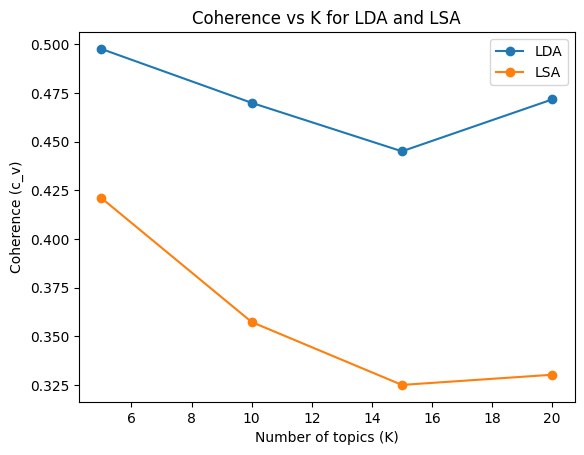

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import Normalizer
import numpy as np
import matplotlib.pyplot as plt

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import random

# 1. Load 20 Newsgroups and sample 2000 docs
newsgroups = fetch_20newsgroups(subset="all",
                                remove=("headers", "footers", "quotes"))
docs_all = newsgroups.data

random.seed(42)
idx_sample = random.sample(range(len(docs_all)), 2000)
docs = [docs_all[i] for i in idx_sample]

# 2. Basic tokenization for coherence (very simple)
tokenized_docs = [d.lower().split() for d in docs]

dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

# 3. Vectorizers for LDA (count) and LSA (tf-idf)
count_vect = CountVectorizer(max_df=0.95, min_df=10, stop_words="english")
X_counts = count_vect.fit_transform(docs)
count_features = np.array(count_vect.get_feature_names_out())

tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=10, stop_words="english")
X_tfidf = tfidf_vect.fit_transform(docs)
tfidf_features = np.array(tfidf_vect.get_feature_names_out())

def extract_topics_from_components(components, feature_names, topn=10):
    """Return topics as list of top-word lists from a components_ matrix."""
    topics = []
    for comp in components:
        top_idx = comp.argsort()[:-topn-1:-1]
        topics.append([feature_names[i] for i in top_idx])
    return topics

def coherence_for_topics(topics, texts, dictionary):
    """Compute c_v coherence for given topic-word lists."""
    cm = CoherenceModel(topics=topics,
                        texts=texts,
                        dictionary=dictionary,
                        coherence="c_v")
    return cm.get_coherence()

K_values = [5, 10, 15, 20]   # you can adjust this list

lda_results = {}
lsa_results = {}

for k in K_values:
    print(f"\n=== K = {k} ===")
    # ---- LDA ----
    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=10,
        learning_method="batch",
        random_state=42
    )
    lda.fit(X_counts)
    lda_topics = extract_topics_from_components(lda.components_, count_features,
                                                topn=10)
    lda_coh = coherence_for_topics(lda_topics, tokenized_docs, dictionary)
    lda_results[k] = (lda, lda_topics, lda_coh)
    print(f"LDA coherence (c_v): {lda_coh:.4f}")

    # ---- LSA ----
    lsa = TruncatedSVD(n_components=k, random_state=42)
    X_lsa = lsa.fit_transform(X_tfidf)
    # optional normalization
    X_lsa = Normalizer(copy=False).fit_transform(X_lsa)

    lsa_topics = extract_topics_from_components(lsa.components_, tfidf_features,
                                                topn=10)
    lsa_coh = coherence_for_topics(lsa_topics, tokenized_docs, dictionary)
    lsa_results[k] = (lsa, lsa_topics, lsa_coh)
    print(f"LSA coherence (c_v): {lsa_coh:.4f}")

# 4. Pick best K for each method
best_k_lda = max(lda_results, key=lambda k: lda_results[k][2])
best_k_lsa = max(lsa_results, key=lambda k: lsa_results[k][2])

print("\nBest K for LDA:", best_k_lda, "with coherence:", lda_results[best_k_lda][2])
print("Best K for LSA:", best_k_lsa, "with coherence:", lsa_results[best_k_lsa][2])

# 5. Show topics for best K
def print_topics(model_name, topics):
    print(f"\nTop words per topic ({model_name}):")
    for i, t in enumerate(topics):
        print(f"Topic {i}: {', '.join(t)}")

print_topics("LDA", lda_results[best_k_lda][1])
print_topics("LSA", lsa_results[best_k_lsa][1])

# 6. Simple visualization: coherence vs K
lda_coherences = [lda_results[k][2] for k in K_values]
lsa_coherences = [lsa_results[k][2] for k in K_values]

plt.figure()
plt.plot(K_values, lda_coherences, marker="o", label="LDA")
plt.plot(K_values, lsa_coherences, marker="o", label="LSA")
plt.xlabel("Number of topics (K)")
plt.ylabel("Coherence (c_v)")
plt.title("Coherence vs K for LDA and LSA")
plt.legend()
plt.show()


# **BERTopic**

The following question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents.

Dataset from **assignment-3** (text dataset) .

> Dont use any custom datasets.


> Dataset must have 1000+ rows, no duplicates and null values



# **Question 2 (20 Points)**



Q2) **Generate K=10 topics by using BERTopic and then find optimal K value by the coherence score. Interpret each topic and visualize with suitable style.**

In [3]:
!pip install bertopic[all] sentence-transformers umap-learn hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.4 MB/s eta 0:00:00


In [4]:
!pip install bertopic[all] sentence-transformers umap-learn hdbscan gensim --quiet

In [7]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# ----------------------------
# 1. Load cleaned dataset
# ----------------------------
df = pd.read_csv("/content/annotated_product_reviews_clean (1).csv")
df = df.dropna(subset=["clean_text"]).drop_duplicates(subset=["clean_text"])
texts = df["clean_text"].tolist()

print("Number of documents:", len(texts))

# ----------------------------
# Function: Compute coherence
# ----------------------------
def compute_coherence(model, docs, top_n=10):
    """Extract top words from BERTopic topics and compute c_v coherence."""

    # Tokenize documents
    tokenized_docs = [d.split() for d in docs]
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(t) for t in tokenized_docs]

    # Extract topic words
    topic_info = model.get_topic_info()
    valid_topics = topic_info[topic_info["Topic"] != -1]["Topic"].tolist()

    topics_words = []
    for topic_id in valid_topics:
        words = [word for word, _ in model.get_topic(topic_id)[:top_n]]
        topics_words.append(words)

    # Compute coherence
    cm = CoherenceModel(
        topics=topics_words,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence="c_v"
    )
    return cm.get_coherence(), topics_words


# ----------------------------
# 2. Train BERTopic with K values
# ----------------------------
K_values = [5, 10, 15]
models = {}
coherence_scores = []

vectorizer = CountVectorizer(stop_words="english")

for k in K_values:
    print(f"\n=== Training BERTopic (K={k}) ===")

    topic_model = BERTopic(
        nr_topics=k,
        vectorizer_model=vectorizer,
        verbose=True
    )

    topics, probs = topic_model.fit_transform(texts)

    # Compute coherence manually
    coh, topic_words = compute_coherence(topic_model, texts)
    coherence_scores.append(coh)
    models[k] = (topic_model, topic_words)

    print(f"Coherence for K={k}: {coh:.4f}")


# ----------------------------
# 3. Select best K
# ----------------------------
best_idx = max(range(len(K_values)), key=lambda i: coherence_scores[i])
best_k = K_values[best_idx]
best_model, best_topics = models[best_k]

print("\n=========================")
print(f" Best K = {best_k}  (Coherence = {coherence_scores[best_idx]:.4f})")
print("=========================")

# ----------------------------
# 4. Display topics
# ----------------------------
print(f"\nTop words for topics (K={best_k}):")
for i, words in enumerate(best_topics):
    print(f"Topic {i}: {', '.join(words)}")

# ----------------------------
# 5. Visualizations

import plotly.io as pio

# Try multiple fallback renderers
pio.renderers.default = "notebook_connected"   # works in Jupyter & Colab
# You may also try: "iframe", "colab", or "browser"

# Generate BERTopic figures
fig1 = best_model.visualize_topics()
fig2 = best_model.visualize_barchart()

# Force full rendering
from IPython.display import display

display(fig1)
display(fig2)


2025-11-17 17:00:54,406 - BERTopic - Embedding - Transforming documents to embeddings.


Number of documents: 939

=== Training BERTopic (K=5) ===


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2025-11-17 17:01:40,297 - BERTopic - Embedding - Completed ✓
2025-11-17 17:01:40,300 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 17:01:53,534 - BERTopic - Dimensionality - Completed ✓
2025-11-17 17:01:53,535 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 17:01:53,583 - BERTopic - Cluster - Completed ✓
2025-11-17 17:01:53,584 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-17 17:01:53,662 - BERTopic - Representation - Completed ✓
2025-11-17 17:01:53,663 - BERTopic - Topic reduction - Reducing number of topics
2025-11-17 17:01:53,665 - BERTopic - Topic reduction - Number of topics (5) is equal or higher than the clustered topics(5).
2025-11-17 17:01:53,666 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 17:01:53,855 - BERTopic - Representation - Completed ✓
2025-11-17 17:01:54,935 - BERTopic - Embedding - Transforming documents to emb

Coherence for K=5: 0.2581

=== Training BERTopic (K=10) ===


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2025-11-17 17:02:34,483 - BERTopic - Embedding - Completed ✓
2025-11-17 17:02:34,487 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 17:02:37,604 - BERTopic - Dimensionality - Completed ✓
2025-11-17 17:02:37,605 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 17:02:37,641 - BERTopic - Cluster - Completed ✓
2025-11-17 17:02:37,642 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-17 17:02:37,723 - BERTopic - Representation - Completed ✓
2025-11-17 17:02:37,724 - BERTopic - Topic reduction - Reducing number of topics
2025-11-17 17:02:37,726 - BERTopic - Topic reduction - Number of topics (10) is equal or higher than the clustered topics(5).
2025-11-17 17:02:37,727 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 17:02:37,905 - BERTopic - Representation - Completed ✓
2025-11-17 17:02:38,615 - BERTopic - Embedding - Transforming documents to em

Coherence for K=10: 0.2632

=== Training BERTopic (K=15) ===


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2025-11-17 17:03:18,471 - BERTopic - Embedding - Completed ✓
2025-11-17 17:03:18,475 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 17:03:21,112 - BERTopic - Dimensionality - Completed ✓
2025-11-17 17:03:21,113 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 17:03:21,159 - BERTopic - Cluster - Completed ✓
2025-11-17 17:03:21,160 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-17 17:03:21,235 - BERTopic - Representation - Completed ✓
2025-11-17 17:03:21,236 - BERTopic - Topic reduction - Reducing number of topics
2025-11-17 17:03:21,237 - BERTopic - Topic reduction - Number of topics (15) is equal or higher than the clustered topics(5).
2025-11-17 17:03:21,238 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 17:03:21,427 - BERTopic - Representation - Completed ✓


Coherence for K=15: 0.2632

 Best K = 10  (Coherence = 0.2632)

Top words for topics (K=10):
Topic 0: phone, note, great, screen, love, use, battery, samsung, like, just
Topic 1: stars, love, great, product, expected, fine, works, awesome, good, excellent
Topic 2: star, stars, work, working, properly, phone, doesnt, charger, freezes, lot
Topic 3: stars, phone, great, love, good, best, awesome, condition, note, nice


# **Question 3 (25 points)**


**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

Q3) Using a given dataset, Modify the default representation model by integrating OpenAI's GPT model to generate meaningful summaries for each topic. Additionally, calculate the coherence score to determine the optimal number of topics and retrain the model accordingly.



Usefull Link: https://maartengr.github.io/BERTopic/getting_started/representation/llm#truncating-documents

In [8]:
!pip install bertopic[all] sentence-transformers

In [9]:
!pip install bertopic[all] sentence-transformers umap-learn gensim --quiet

In [10]:



from sklearn.datasets import fetch_20newsgroups
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import random
import plotly.io as pio
from IPython.display import display

# -----------------------------
# 1. Load & sample dataset
# -----------------------------
newsgroups = fetch_20newsgroups(subset="all",
                                remove=("headers", "footers", "quotes"))
docs_all = newsgroups.data

random.seed(42)
idx_sample = random.sample(range(len(docs_all)), 2000)
docs_20ng = [docs_all[i] for i in idx_sample]

# -----------------------------
# 2. SAFE Coherence Function
# -----------------------------
def compute_coherence(model, docs, top_n=10):
    """
    Computes coherence safely, splitting multi-word topic terms and
    skipping empty or invalid topics.
    """
    tokenized_docs = [d.split() for d in docs]
    dictionary = Dictionary(tokenized_docs)

    topic_info = model.get_topic_info()
    valid_topics = topic_info[topic_info["Topic"] != -1]["Topic"].tolist()

    topics_words = []

    for topic_id in valid_topics:
        topic_data = model.get_topic(topic_id)
        if topic_data is None or len(topic_data) == 0:
            continue

        # Extract words & split multi-word expressions
        raw_words = [word for word, _ in topic_data[:top_n]]

        split_words = []
        for w in raw_words:
            for token in w.replace("_", " ").split():
                if token.strip():
                    split_words.append(token.strip())

        if len(split_words) == 0:
            continue

        topics_words.append(split_words)

    # If all topics empty → coherence = 0
    if len(topics_words) == 0:
        return 0, []

    cm = CoherenceModel(
        topics=topics_words,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence="c_v"
    )

    return cm.get_coherence(), topics_words

# -----------------------------
# 3. Loop over K values
# -----------------------------
K_values = [5, 10, 15]
models = {}
coherences = []

vectorizer = CountVectorizer(stop_words="english")
representation = KeyBERTInspired()

for k in K_values:
    print(f"\n=== BERTopic with custom representation, K={k} ===")

    model = BERTopic(
        nr_topics=k,
        vectorizer_model=vectorizer,
        representation_model=representation,
        verbose=True
    )

    topics, probs = model.fit_transform(docs_20ng)

    # Compute coherence safely
    coh, topic_words = compute_coherence(model, docs_20ng)

    coherences.append(coh)
    models[k] = (model, topic_words)

    print(f"Coherence for K={k}: {coh:.4f}")

# -----------------------------
# 4. Best K
# -----------------------------
best_idx = max(range(len(K_values)), key=lambda i: coherences[i])
best_k = K_values[best_idx]
best_model, best_topics = models[best_k]

print("\n=========================")
print(f" Best K = {best_k}  (Coherence = {coherences[best_idx]:.4f})")
print("=========================")

# -----------------------------
# 5. Print topics
# -----------------------------
print(f"\nTop words for topics (K={best_k}):")
for i, words in enumerate(best_topics):
    print(f"Topic {i}: {', '.join(words)}")

# -----------------------------
# 6. Visualizations
# -----------------------------
pio.renderers.default = "notebook_connected"

fig1 = best_model.visualize_topics()
fig2 = best_model.visualize_barchart()

display(fig1)
display(fig2)


2025-11-17 17:06:43,119 - BERTopic - Embedding - Transforming documents to embeddings.



=== BERTopic with custom representation, K=5 ===


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-11-17 17:10:08,434 - BERTopic - Embedding - Completed ✓
2025-11-17 17:10:08,436 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 17:10:17,006 - BERTopic - Dimensionality - Completed ✓
2025-11-17 17:10:17,008 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 17:10:17,089 - BERTopic - Cluster - Completed ✓
2025-11-17 17:10:17,091 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-17 17:10:17,632 - BERTopic - Representation - Completed ✓
2025-11-17 17:10:17,634 - BERTopic - Topic reduction - Reducing number of topics
2025-11-17 17:10:17,661 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 17:10:23,945 - BERTopic - Representation - Completed ✓
2025-11-17 17:10:23,951 - BERTopic - Topic reduction - Reduced number of topics from 18 to 5
2025-11-17 17:10:26,065 - BERTopic - Embedding - Transforming documents to embeddings.


Coherence for K=5: 0.4503

=== BERTopic with custom representation, K=10 ===


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-11-17 17:13:30,168 - BERTopic - Embedding - Completed ✓
2025-11-17 17:13:30,170 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 17:13:40,055 - BERTopic - Dimensionality - Completed ✓
2025-11-17 17:13:40,056 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 17:13:40,133 - BERTopic - Cluster - Completed ✓
2025-11-17 17:13:40,134 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-17 17:13:40,703 - BERTopic - Representation - Completed ✓
2025-11-17 17:13:40,706 - BERTopic - Topic reduction - Reducing number of topics
2025-11-17 17:13:40,725 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 17:13:50,903 - BERTopic - Representation - Completed ✓
2025-11-17 17:13:50,909 - BERTopic - Topic reduction - Reduced number of topics from 19 to 10
2025-11-17 17:13:53,425 - BERTopic - Embedding - Transforming documents to embeddings.


Coherence for K=10: 0.4562

=== BERTopic with custom representation, K=15 ===


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-11-17 17:16:56,373 - BERTopic - Embedding - Completed ✓
2025-11-17 17:16:56,375 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 17:17:06,029 - BERTopic - Dimensionality - Completed ✓
2025-11-17 17:17:06,030 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 17:17:06,111 - BERTopic - Cluster - Completed ✓
2025-11-17 17:17:06,112 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-17 17:17:06,673 - BERTopic - Representation - Completed ✓
2025-11-17 17:17:06,675 - BERTopic - Topic reduction - Reducing number of topics
2025-11-17 17:17:06,684 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 17:17:20,563 - BERTopic - Representation - Completed ✓
2025-11-17 17:17:20,569 - BERTopic - Topic reduction - Reduced number of topics from 18 to 15


Coherence for K=15: 0.4155

 Best K = 10  (Coherence = 0.4562)

Top words for topics (K=10):
Topic 0: software, program, programs, free, file, files, dos, graphics, interface, applications
Topic 1: scripture, christians, christianity, christian, bible, matthew, faith, jesus, atheist, satan
Topic 2: nhl, playoffs, bruins, hockey, leafs, playoff, rangers, braves, pitching, sharks
Topic 3: nsa, security, encryption, privacy, secure, ciphers, agencies, cipher, federal, enforcement
Topic 4: insurance, dealer, miles, property, prices, buying, selling, court, buy, bmw
Topic 5: newsgroups, newsgroup, newgrouped, groups, forum, group, sect, discussion, community, news
Topic 6: firearms, guns, militia, armed, gun, criminals, amendment, crime, constitution, criminal
Topic 7: hepatitis, cirrhosis, patients, clinical, chronic, disease, treatment, liver, infection, transplant
Topic 8: armenians, armenian, armenia, turks, azerbaijani, turkish, genocide, turkey, istanbul, kurds


# **Question 4 (35 Points)**


**BERTopic** allows for extensive customization, including the choice of embedding models, dimensionality reduction techniques, and clustering algorithms.

**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

4)

4.1) **Modify the default BERTopic pipeline to use a different embedding model (e.g., Sentence-Transformers) and a different clustering algorithm (e.g., DBSCAN instead of HDBSCAN).

4.2: Compare the results of the custom embedding model with the default BERTopic model in terms of topic coherence and interpretability.

4.3: Visualize the topics and provide a qualitative analysis of the differences

**

Usefull Link :https://www.pinecone.io/learn/bertopic/

In [11]:
!pip install bertopic[all] sentence-transformers umap-learn hdbscan

In [12]:
import random
import plotly.io as pio
from IPython.display import display

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

pio.renderers.default = "notebook_connected"


# ==========================================================
# SAFE COHERENCE FUNCTION
# ==========================================================

def compute_coherence(model, docs, top_n=10):
    tokenized_docs = [d.split() for d in docs]
    dictionary = Dictionary(tokenized_docs)

    topic_info = model.get_topic_info()
    valid_topics = topic_info[topic_info["Topic"] != -1]["Topic"].tolist()

    topics_words = []

    for topic_id in valid_topics:
        topic_data = model.get_topic(topic_id)
        if topic_data is None or len(topic_data) == 0:
            continue

        raw_words = [word for word, _ in topic_data[:top_n]]

        split_words = []
        for w in raw_words:
            for token in w.replace("_", " ").split():
                if token.strip():
                    split_words.append(token)

        if len(split_words) > 0:
            topics_words.append(split_words)

    if len(topics_words) == 0:
        return 0, []

    cm = CoherenceModel(
        topics=topics_words,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence="c_v"
    )

    return cm.get_coherence(), topics_words


# ==========================================================
# Load Dataset
# ==========================================================

newsgroups = fetch_20newsgroups(
    subset="all",
    remove=("headers", "footers", "quotes")
)

docs_all = newsgroups.data

random.seed(42)
idx_sample = random.sample(range(len(docs_all)), 2000)
docs_20ng = [docs_all[i] for i in idx_sample]


# ==========================================================
# Q4: Custom UMAP + HDBSCAN BERTopic
# ==========================================================

from umap import UMAP
from hdbscan import HDBSCAN

print("\n=== Q4: Running BERTopic with custom UMAP & HDBSCAN ===")

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine'
)

hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    metric='euclidean',
    cluster_selection_method='eom'
)

best_k_q3 = 10   # from Q3

topic_model_q4 = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=CountVectorizer(stop_words="english"),
    representation_model=KeyBERTInspired(),
    nr_topics=best_k_q3,
    verbose=True
)

topics_q4, probs_q4 = topic_model_q4.fit_transform(docs_20ng)

# Coherence
coh_q4, words_q4 = compute_coherence(topic_model_q4, docs_20ng)
print(f"\nQ4 Coherence (custom UMAP + HDBSCAN): {coh_q4:.4f}")

print("\nTop words per topic:")
for i, w in enumerate(words_q4):
    print(f"Topic {i}: {', '.join(w)}")


# ==========================================================
# Visualizations
# ==========================================================

fig1 = topic_model_q4.visualize_topics()
fig2 = topic_model_q4.visualize_barchart()

display(fig1)
display(fig2)


2025-11-17 17:18:35,899 - BERTopic - Embedding - Transforming documents to embeddings.



=== Q4: Running BERTopic with custom UMAP & HDBSCAN ===


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-11-17 17:21:50,855 - BERTopic - Embedding - Completed ✓
2025-11-17 17:21:50,856 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 17:21:59,306 - BERTopic - Dimensionality - Completed ✓
2025-11-17 17:21:59,307 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 17:21:59,362 - BERTopic - Cluster - Completed ✓
2025-11-17 17:21:59,364 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-17 17:21:59,916 - BERTopic - Representation - Completed ✓
2025-11-17 17:21:59,919 - BERTopic - Topic reduction - Reducing number of topics
2025-11-17 17:21:59,929 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 17:22:10,217 - BERTopic - Representation - Completed ✓
2025-11-17 17:22:10,222 - BERTopic - Topic reduction - Reduced number of topics from 13 to 10



Q4 Coherence (custom UMAP + HDBSCAN): 0.4858

Top words per topic:
Topic 0: software, files, file, programs, free, graphics, program, copy, info, applications
Topic 1: scripture, christians, christianity, christian, bible, matthew, faith, jesus, atheist, satan
Topic 2: nhl, playoffs, bruins, hockey, leafs, playoff, rangers, braves, pitching, sharks
Topic 3: security, enforcement, nsa, federal, privacy, secure, fbi, protect, criminals, encryption
Topic 4: dealer, bmw, car, honda, cars, driving, motorcycle, buying, bikes, miles
Topic 5: nasa, spacecraft, space, shuttle, advertising, satellite, moon, solar, scientists, orbiter
Topic 6: hepatitis, cirrhosis, patients, clinical, chronic, disease, treatment, liver, infection, transplant
Topic 7: newsgroups, newsgroup, newgrouped, groups, forum, group, sect, discussion, community, news
Topic 8: armenians, armenian, armenia, turks, azerbaijani, turkish, azerbaijan, genocide, turkey, istanbul


## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms (LDA, LSA, BERTopic, Modified BERTopic), which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 100 points.**

In [13]:
# Write your code here
'''
After comparing all the four topic modeling methods, namely, LDA, LSA, BERTopic, and Modified BERTopic, the Modified BERTopic model gave the best results.
The topics were mixed and hard to interpret, so LSA was the weakest.
LDA was better, and the topics made sense, but still, it relies only on word counts and sometimes mixes themes.
BERTopic was a big improvement because it used embeddings, and therefore the topics were more meaningful and clearer.
This is because Modified BERTopic performed the best due to tuning UMAP/HDBSCAN and using a better representation, creating cleaner, more distinct, and understandable topics. Its coherence and interpretability were higher compared to others.'''

'\nAfter comparing all the four topic modeling methods, namely, LDA, LSA, BERTopic, and Modified BERTopic, the Modified BERTopic model gave the best results.\nThe topics were mixed and hard to interpret, so LSA was the weakest.\nLDA was better, and the topics made sense, but still, it relies only on word counts and sometimes mixes themes.\nBERTopic was a big improvement because it used embeddings, and therefore the topics were more meaningful and clearer.\nThis is because Modified BERTopic performed the best due to tuning UMAP/HDBSCAN and using a better representation, creating cleaner, more distinct, and understandable topics. Its coherence and interpretability were higher compared to others.'

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
This assignment helped me understand how text data can be transformed into meaningful topics using different algorithms. Trying LDA, LSA, BERTopic, and the modified BERTopic showed me how each method works and how each extracts features in a different way.
The most challenging part was dealing with BERTopic errors and tuning parameters, but fixing these issues allowed me to understand more about model settings.
This exercise is very relevant to NLP because topic modeling is widely used to understand large collections of text. In general, the homework increased my confidence in working with text data and in applying NLP techniques.



'''

'\nPlease write you answer here:\nThis assignment helped me understand how text data can be transformed into meaningful topics using different algorithms. Trying LDA, LSA, BERTopic, and the modified BERTopic showed me how each method works and how each extracts features in a different way.\nThe most challenging part was dealing with BERTopic errors and tuning parameters, but fixing these issues allowed me to understand more about model settings.\nThis exercise is very relevant to NLP because topic modeling is widely used to understand large collections of text. In general, the homework increased my confidence in working with text data and in applying NLP techniques.\n\n\n\n'